# https://www.kaggle.com/c/mercari-price-suggestion-challenge 
# https://www.kaggle.com/c/home-credit-default-risk

Выбрать одно из двух соревнований. Выбирайте по данным, с которыми вам интереснее работать.

In [72]:
import time
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler,  Imputer, LabelBinarizer, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import gc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
# Ансамбли

import xgboost as xgb
import lightgbm as lgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Задание
1. Сделать baseline submission
  * Исследовать признак price. 
  * Исследовать признак price в зависимости от brand_name или других признаков
2. Реализовать цикл анализа
  * признаки -> модель -> настройка параметров -> лучшая модель и ее значение метрики качества на кросс-валидации
3. Провести простые преобразования признаков и добавление простых признаков
  * разделить category_name на уровни
  * посмотреть на наличие числовых значений в описании и имени
4. Составить план по применению нескольких моделей на разных признаках
  * спроектируйте эксперимент. Нужно заранее спланировать порядок перебора признаков и моделей. Потом только писать код. Обратный порядок вызывает необходимость переписывать существующий код, это трата времени
5. Просмотреть 1-5 kernel на kaggle. (только в таком порядке. сначала работаем самостоятельно, потом смотрим идеи других. при появлении опыта можно сразу начинать с них)
6. Построить модель, выбрать лучшую
7. Построить ансамбль, настрить парамертры. Сравнить с другими моделями.
8. Оценить качество на CV.

In [5]:

train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep = '\t')
print(train.shape, test.shape)
train.head()

(1482535, 8) (693359, 7)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.00,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.00,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.00,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.00,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.00,0,Complete with certificate of authenticity


**Посмотрим на распределение признака price**

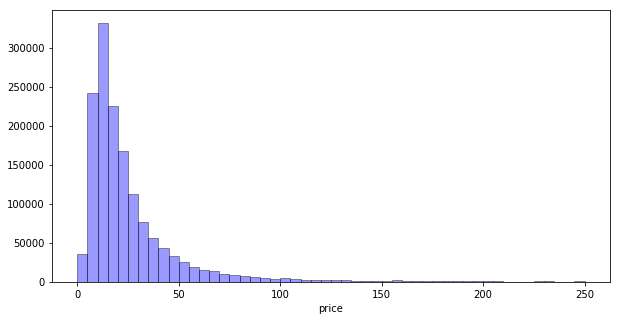

In [6]:
plt.figure(figsize = (10,5))
sns.distplot(train.query("""price <=250""")['price'], hist=True, kde=False, bins=50, 
             color = 'blue', hist_kws={'edgecolor':'black'});

Мы имеем ненормальное распределение с вытянутым хвостом. Популярные значение цены - около 20. Есть выбросы 
<br> Сделаем лог преобразование

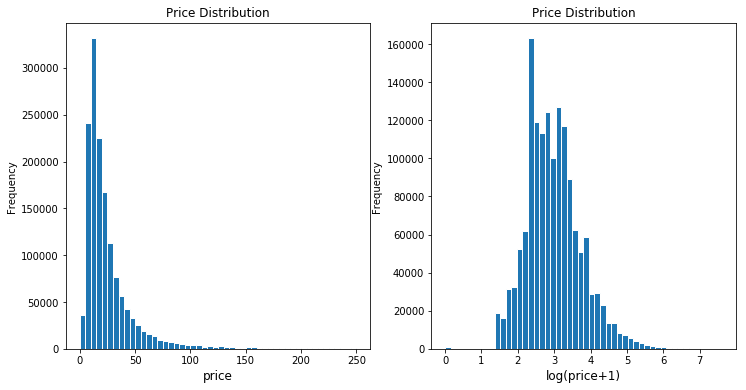

In [7]:
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12);
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12);

**В 55% заказов доставка была оплачена покупателем**

In [8]:
train['shipping'].value_counts() / len(train)

0   0.55
1   0.45
Name: shipping, dtype: float64

**В среднем цена выше где покупатель сам платит за доставку**

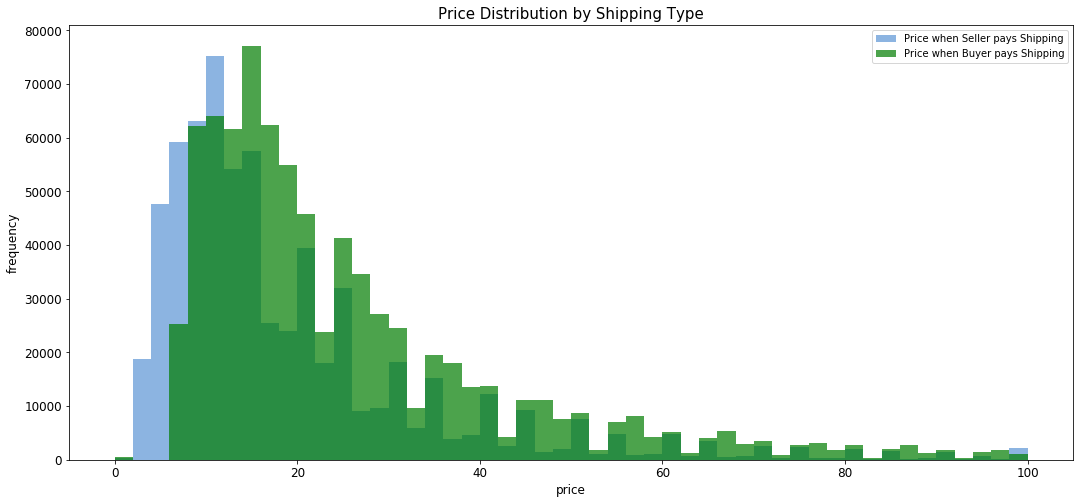

In [9]:
shipping_fee_by_buyer = train.loc[train['shipping'] == 0, 'price']
shipping_fee_by_seller = train.loc[train['shipping'] == 1, 'price']
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [10]:
# топ 10 популярных категории
train['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: category_name, dtype: int64

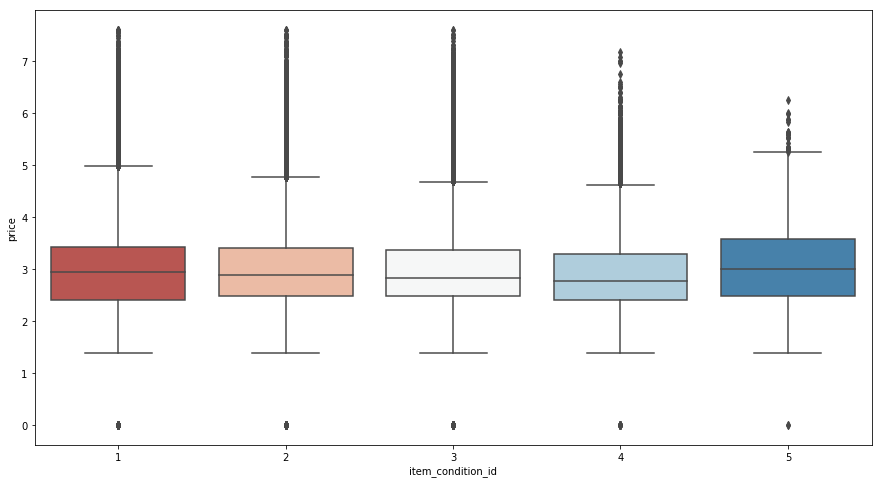

In [11]:
# Распределение цен по item_condition_id
sns.boxplot(x = 'item_condition_id', y = np.log(train['price']+1), 
            data = train, palette = sns.color_palette('RdBu',5));

### FE

In [12]:
#constrains
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 10000

In [13]:
Y_TRAIN = np.log1p(train['price'])
tr_ids = train['train_id'].values.astype(np.int32)
train.drop(['price', 'train_id'], axis=1, inplace=True)
te_ids = test['test_id'].values.astype(np.int32)
test.drop(['test_id'], axis=1, inplace=True)

df = pd.concat([train, test])
nrow_train = train.shape[0]
del train, test
gc.collect()

3946

In [14]:
#helper functions
def handle_missing_inplace(dataset): 
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)
def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    #dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

# Сделаем преобразование
handle_missing_inplace(df)
cutting(df)
to_categorical(df)

In [15]:
df.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,0,Complete with certificate of authenticity


**Обработаем текстовые фичи**

In [16]:
%%time
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(df['name'])
print('pass xname')
cv = CountVectorizer()
X_category = cv.fit_transform(df['category_name'])
print('pass cv')
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(df['item_description'])
print('pass tv')

lb = LabelBinarizer(sparse_output = True)
X_brand = lb.fit_transform(df['brand_name'])
print('pass xbrand')

X_dummies = csr_matrix(pd.get_dummies(df[['item_condition_id', 'shipping']], sparse=True).values)
print('pass x dummies')

sparse_df = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()


pass xname
pass cv
pass tv
pass xbrand
pass x dummies
CPU times: user 8min 59s, sys: 44.5 s, total: 9min 44s
Wall time: 10min 11s


In [17]:
sparse_df

<2175894x36286 sparse matrix of type '<class 'numpy.float64'>'
	with 61436360 stored elements in Compressed Sparse Row format>

**Применим несколько моделей на CV и выберем лучшую**

In [18]:
#Вспомогательные функции обертки
        
class LightGBMWrapper():
    def __init__(self, seed=0, params=None):
        self.params = params
        self.params['seed'] = seed
        self.verbose = params.pop('verbose', 50)

    def train(self, x_train, y_train):
        self.model = lgb.LGBMModel(**self.params)
        self.model.fit(x_train, y_train, eval_set = [(x_train, y_train)], verbose = self.verbose)
    def predict(self, x):
        return self.model.predict(x)


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.model = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.model.predict(xgb.DMatrix(x))

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    


In [19]:
#df_main = pd.DataFrame(sparse_df.todense())

In [67]:

X_TRAIN = sparse_df[:nrow_train]
X_TEST = sparse_df[nrow_train:]
NTRAIN = X_TRAIN.shape[0]
NTEST = X_TEST.shape[0]

NFOLDS = 3
SEED = 0
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

xgb_params = {
    'objective': 'reg:linear',
    'eval_metric':'rmse', 
    'verbosity': 0
}
lightgbm_params = {
        'boosting_type': 'gbdt',
        'learning_rate': 0.75,
        'max_depth': 3,
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': 50,
    }
ridge_params = {
    'solver':"lsqr"
}

#out of fold 
def get_oof(clf):
    oof_train = np.zeros((NTRAIN,))
    oof_test = np.zeros((NTEST,))
    oof_test_skf = np.empty((NFOLDS, NTEST))

    for i, (train_index, test_index) in enumerate(kf.split(X_TRAIN)):
        x_tr = X_TRAIN[train_index]
        y_tr = Y_TRAIN[train_index]
        x_te = X_TRAIN[test_index]
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_TEST)


    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


#xg = XgbWrapper(seed=SEED, params=xgb_params)
rg = SklearnWrapper(clf = Ridge, seed = SEED, params = ridge_params)
lg = LightGBMWrapper(seed = SEED, params = lightgbm_params)

print('Train ridge')
rg_oof_train, rg_oof_test = get_oof(rg)
print('Train LightGBM')
lg_oof_train, lg_oof_test  = get_oof(lg)

# print('Train xgboost')
# xg_oof_train = get_oof(xg)


print('----------------------------------------------------------------')

ridge_oof_RMSLE = np.sqrt(mean_squared_error(Y_TRAIN, rg_oof_train))
lgb_oof_RMSLE = np.sqrt(mean_squared_error(Y_TRAIN, lg_oof_train))
#xgb_oof_RMSLE = np.sqrt(mean_squared_error(Y_TRAIN, xg_oof_train))



Train ridge


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


Train LightGBM
[50]	training's rmse: 0.566617
[100]	training's rmse: 0.540772
[50]	training's rmse: 0.565674
[100]	training's rmse: 0.540063
[50]	training's rmse: 0.565794
[100]	training's rmse: 0.540531
----------------------------------------------------------------


In [70]:
print('ridge cv score', ridge_oof_RMSLE)
print('lgb cv score', lgb_oof_RMSLE)
#print('xgb cv score', xgb_oof_RMSLE)

ridge cv score 0.4756708394741647
lgb cv score 0.5423646336091389


In [ ]:
#Сделаем финальный сабмишн
model = Ridge()
model.fit(X_TRAIN, Y_TRAIN)
preds = np.expm1(model.predict(X_TEST))
preds.to_csv('submission.csv', index = False)

### Попробуем комбинацию моделей

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, random_state=42)

X_in, X_out, y_in, y_out = train_test_split(X_train, y_train, random_state=42) # hold-out - blending. 

rg.train(X_in, y_in)
lg.train(X_in, y_in)

rg_y = rg.predict(X_out)
lg_y = lg.predict(X_out)


lr = LinearRegression()
lr.fit(np.c_[rg_y, lg_y], y_out)

y_stack = lr.predict(np.c_[rg.predict(X_test), lg.predict(X_test)])

print('score stacked ', np.sqrt(mean_squared_error(y_test, y_stack)))
print('score LightGbm ', np.sqrt(mean_squared_error(y_test, lg.predict(X_test))))
print('score Ridge ', np.sqrt(mean_squared_error(y_test, rg.predict(X_test))))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


[50]	training's rmse: 0.566761
[100]	training's rmse: 0.541469
score stacked  0.47448752726369786
score LightGbm  0.5439689231602463
score Ridge  0.4774583451675049


**качество немного выросло по сравнению с Ridge**

In [78]:
#самбишн
np.expm1(lr.predict(np.c_[rg.predict(X_TRAIN), lg.predict(X_TRAIN)]))

array([ 9.38942884, 71.16364696, 10.64414701, ..., 20.25815266,
       12.25641814, 34.30097752])